# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [71]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [72]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros(Nclasses)

    # TODO: compute the values of prior for each class!
    # ==========================
    for i,c in enumerate(classes):
        idx = np.where(labels==c)[0]
        X_ci = labels[idx]
        prior[i] = X_ci.shape[0]/Npts
    # ==========================
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    for i,c in enumerate(classes):
        idx = labels==c # Returns a true or false with the length of y
        # Or more compactly extract the indices for which y==class is true,
        # analogous to MATLAB’s find
        idx = np.where(labels==c)[0]
        X_ci = X[idx, :]
        mu[i, :] = np.mean(X_ci, axis=0)
        # for d in range(Ndims):
        #     offset = np.zeros((len(X_ci), Ndims))
        #     offset[:, d] = X_ci[:, d] - mu[i, d]
        #     # print(np.sum(offset**2, axis=0)/len(X_ci))
        #     sigma[i, d, d] = np.sum(offset**2)/len(X_ci)

        offset = X_ci - mu[i, :]
        avgOffset = np.mean(offset**2, axis=0)
        sigma[i, :, :] = np.diag(avgOffset)
    # ==========================

    return mu, sigma



## with Weights

functions with weights for boosting

In [73]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros(Nclasses)

    # TODO: compute the values of prior for each class!
    # ==========================
    for i,c in enumerate(classes):
        idx = np.where(labels==c)[0]
        W_ci = W[idx]
        prior[i] = np.sum(W_ci)/np.sum(W)
    # ==========================
    return prior

def cal_Cov(X1, W):
    cov = np.zeros((X1.shape[1], X1.shape[1]))
    for i in range(X1.shape[1]):
        centrX = X1[:,i] - np.mean(X1[:,i])
        cov[i, i] = np.dot(np.multiply(centrX, centrX), W)/np.sum(W)
    return cov

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    for i,c in enumerate(classes):
        idx = labels==c # Returns a true or false with the length of y
        # Or more compactly extract the indices for which y==class is true,
        # analogous to MATLAB’s find
        idx = np.where(labels==c)[0]
        X_ci = X[idx]
        W_ci = W[idx]
        mu[i, :] = np.dot(np.transpose(W_ci), X_ci)/np.sum(W_ci)

        # offset = X_ci - mu[i, :]
        # avgOffset = np.dot(np.transpose(W_ci), offset**2)/np.sum(W_ci)
        # sigma[i, :, :] = np.diag(avgOffset[0])
        sigma[i, :, :] = cal_Cov(X_ci, W_ci)
    # ==========================
    return mu, sigma

## Classifier

Classification using discriminant function

In [74]:
# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    for i in range(Nclasses):
        for j in range(Npts):
            offset = X[j] - mu[i]
            t1 = -0.5*np.log(np.linalg.det(sigma[i]))
            t2 = -0.5*np.dot(np.dot(offset, np.linalg.inv(sigma[i])), np.transpose(offset))
            t3 = np.log(prior[i])
            logProb[i, j] = t1 + t2 + t3
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [75]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

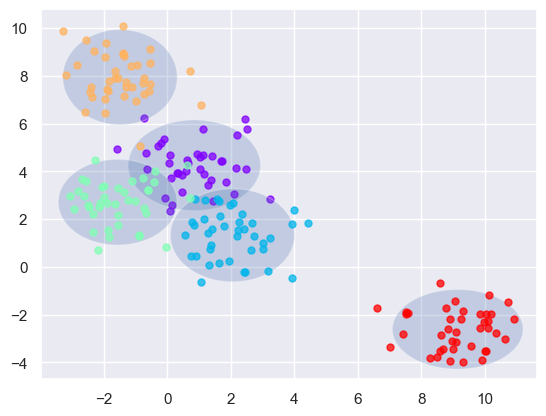

In [5]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [59]:
testClassifier(BayesClassifier(), dataset='iris', split=0.8)

Trial: 0 Accuracy 83.3
Trial: 10 Accuracy 93.3
Trial: 20 Accuracy 90
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 90
Trial: 60 Accuracy 83.3
Trial: 70 Accuracy 90
Trial: 80 Accuracy 80
Trial: 90 Accuracy 83.3
Final mean classification accuracy  88.8 with standard deviation 5.69


In [61]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.8)

Trial: 0 Accuracy 56.4
Trial: 10 Accuracy 63.6
Trial: 20 Accuracy 70.9
Trial: 30 Accuracy 67.3
Trial: 40 Accuracy 55.5
Trial: 50 Accuracy 63.6
Trial: 60 Accuracy 64.5
Trial: 70 Accuracy 64.5
Trial: 80 Accuracy 59.1
Trial: 90 Accuracy 65.5
Final mean classification accuracy  64.4 with standard deviation 4.59


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

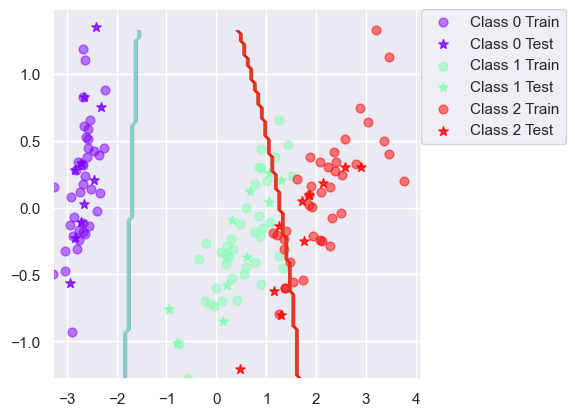

In [78]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.8)

1. When can a feature independence assumption be reasonable and when not?

    Feature independence in real-life is a very rare find. Often enouph the assumption of feature independence can still be reasonable. The reason is that it makes the classifier more biased and reduces its variance. This is often disarable, especially when data is limited. For extremly large amounts of data it can make sence to pick the QLA (Quadratic Discriminant Analysis) over a Naive bayes classifier.

2. How does the decision boundary look for the Iris dataset? How could one improve the classification results for this scenario by changing classifier or, alternatively, manipulating the data?

    While the boundary for class 0 is placed well, the boundary between class 1 and 2 is bad. The classifier failed to position the boundary correctly in space. A SVM or even KNN classifier would have probably been able to produce more confincing results. If we could manipulate the data in a way that creates a cleaner sparation between the two classes the classification is likely to improve.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

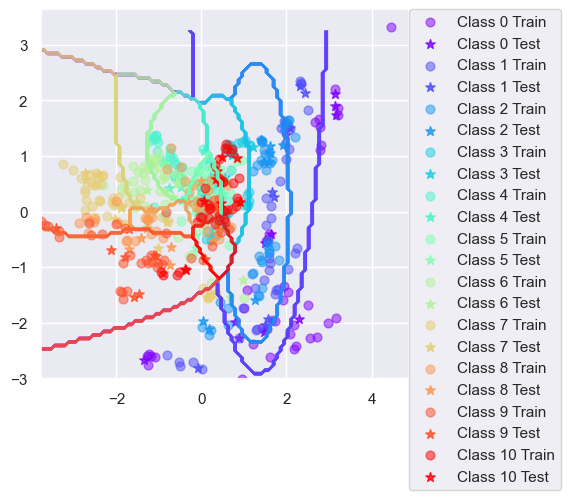

In [79]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='vowel',split=0.8)

## Boosting functions to implement

The lab descriptions state what each function should do.

In [45]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        delta = np.where(vote == labels, 1, 0)
        error = np.dot(wCur.reshape(-1), (1 - delta))
        alpha = 0.5*(np.log(1-error)-np.log(error))

        update = np.where(vote == labels, np.exp(-alpha), np.exp(alpha))
        update = update.reshape((update.size, 1)) # make same shape as wCur
        wCur = wCur * update
        wCur = wCur/np.sum(wCur)

        alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        for t in range(Ncomps):
            vote = classifiers[t].classify(X)
            for x in range(Npts):
                votes[x, vote[x]] += alphas[t]
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [46]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [56]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.8)

Trial: 0 Accuracy 96.7
Trial: 10 Accuracy 90
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 96.7
Trial: 40 Accuracy 100
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 86.7
Final mean classification accuracy  95.1 with standard deviation 3.45


In [64]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.8)

Trial: 0 Accuracy 74.5
Trial: 10 Accuracy 83.6
Trial: 20 Accuracy 82.7
Trial: 30 Accuracy 79.1
Trial: 40 Accuracy 69.1
Trial: 50 Accuracy 78.2
Trial: 60 Accuracy 83.6
Trial: 70 Accuracy 84.5
Trial: 80 Accuracy 82.7
Trial: 90 Accuracy 85.5
Final mean classification accuracy  80.8 with standard deviation 3.9


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

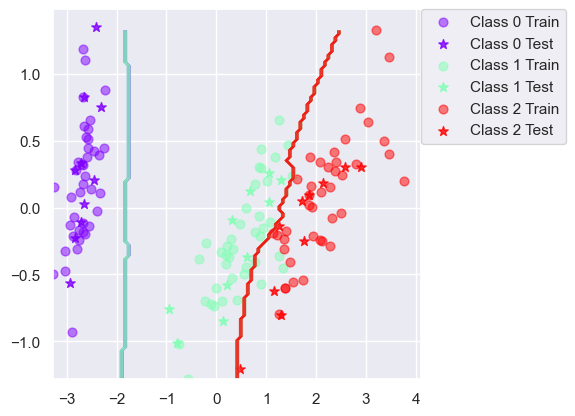

In [80]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.8)

1. Is there any improvement in classification accuracy? Why/why not?

    Iris
    - no boosting: 88.8 with standard deviation 5.69
    - w/ boosting: 95.1 with standard deviation 3.45

    Vowels:
    - no boosting: 64.4 with standard deviation 4.59
    - w/ boosting: 80.8 with standard deviation 3.9

    Boosting significantly improved the accuracy on both datasets.
    Especially on the vowels dataset. Boosting allows the classifier to more accuratly model the class distribution, because of increased variance.

2. Plot the decision boundary of the boosted classifier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

    The decision boundary is more complex and follows the actual distribution of the data much closer. The model is much more flexible.

3. Can we make up for not using a more advanced model in the basic classifier (e.g. independent features) by using boosting?

    Yes, we can (to a certain degree). As we can see from the decision boundaries, boosting essentially lowers the bias of the classifier and increases the variance resulting in a better fit to the data.

Of course, this can not make up for a classifier that is simply not able to accuratly model the complexity of the data distribution.

## Now repeat the steps with a decision tree classifier.

In [82]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.8)

Trial: 0 Accuracy 93.3
Trial: 10 Accuracy 100
Trial: 20 Accuracy 90
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 100
Trial: 50 Accuracy 90
Trial: 60 Accuracy 83.3
Trial: 70 Accuracy 96.7
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 83.3
Final mean classification accuracy  93 with standard deviation 4.87


In [83]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.8)

Trial: 0 Accuracy 67.3
Trial: 10 Accuracy 72.7
Trial: 20 Accuracy 70.9
Trial: 30 Accuracy 69.1
Trial: 40 Accuracy 65.5
Trial: 50 Accuracy 59.1
Trial: 60 Accuracy 62.7
Trial: 70 Accuracy 67.3
Trial: 80 Accuracy 60
Trial: 90 Accuracy 63.6
Final mean classification accuracy  65 with standard deviation 4.29


In [84]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.8)

Trial: 0 Accuracy 100
Trial: 10 Accuracy 100
Trial: 20 Accuracy 90
Trial: 30 Accuracy 96.7
Trial: 40 Accuracy 100
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 96.7
Trial: 80 Accuracy 96.7
Trial: 90 Accuracy 90
Final mean classification accuracy  95.1 with standard deviation 4.33


In [85]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.8)

Trial: 0 Accuracy 87.3
Trial: 10 Accuracy 88.2
Trial: 20 Accuracy 90
Trial: 30 Accuracy 94.5
Trial: 40 Accuracy 85.5
Trial: 50 Accuracy 85.5
Trial: 60 Accuracy 82.7
Trial: 70 Accuracy 87.3
Trial: 80 Accuracy 87.3
Trial: 90 Accuracy 87.3
Final mean classification accuracy  88.2 with standard deviation 2.95


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

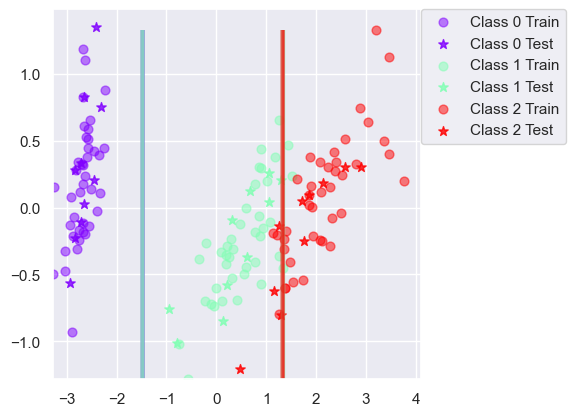

In [86]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.8)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

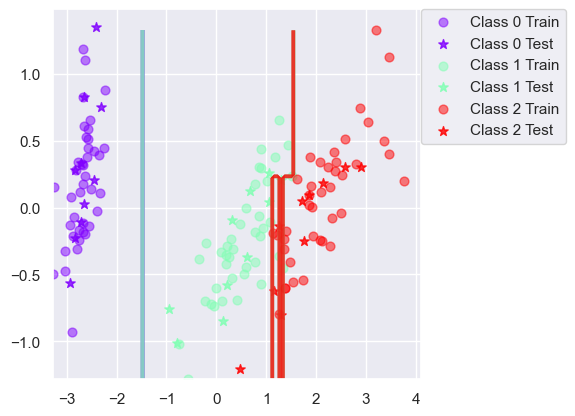

In [99]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.8)

1. Is there any improvement in classification accuracy? Why/why not?

    Iris
    - no boosting: 93 with standard deviation 4.87
    - w/ boosting: 95.1 with standard deviation 4.33

    Vowels:
    - no boosting: 65 with standard deviation 4.29
    - w/ boosting: 88.2 with standard deviation 2.95

    Boosting significantly improved the performance of the Decision Tree Classifier. Especially on the vowels dataset, where it can even outperform the Naive Bayes Classifier

2. Plot the decision boundary of the boosted classifier on iris and compare it with that of the basic. What differences do you notice? Is the boundary of the boosted version more complex?

    The decision boundary is more complex and follows the actual distribution of the data much closer. The model is much more flexible.

3. Can we make up for not using a more advanced model in the basic classifier (e.g. independent features) by using boosting?

    Yes, we can (to a certain degree). As we can see from the decision boundaries, boosting essentially lowers the bias of the classifier and increases the variance resulting in a better fit to the data.

    Of course, this can not make up for a classifier that is simply not able to accuratly model the complexity of the data distribution.

## Final Question

If you had to pick a classifier, naive Bayes or a decision tree or
the boosted versions of these, which one would you pick? Motivate from the following
criteria:
- Outliers
- Irrelevant inputs: part of the feature space is irrelevant
- Predictive power
- Mixed types of data: binary, categorical or continuous features, etc.
- Scalability: the dimension of the data, D, is large or the number of instances, N, is large, or both.

## Answer

- Outliers:
I believe naive bayes with a low amount of boosting should be a good choice here, to take the outliers into account but not overfit on them.

- Irrelevant inputs:
A tree show approach should be well suited to ignore irrelevant features in the feature space. Because it can devide the space at each node and only continue with relevant data.

- Predictive Power:
The experiments in this assignment have shown that Naive Bayes with boosting seems to consitently outperform decision trees in terms of their predictive power

- Mixed types of data:
Both Naive Bayes and decision trees are capable of dealing with mixed data without needing to rely on dummy variables.

- Scalability:
Naive Bayes should scale pretty well. Naive Bayes performs well when D is large and a higher variance is benefitial. Trees have trouble scaling to very large datasets, because they can grow massive. In the case of large N boosting becomes more expensive and likely less relevant for the performance of the classifier.

# Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [100]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.8, dim=20)

Trial: 0 Accuracy 93.8
Trial: 10 Accuracy 87.5
Trial: 20 Accuracy 93.8
Trial: 30 Accuracy 90
Trial: 40 Accuracy 92.5
Trial: 50 Accuracy 88.8
Trial: 60 Accuracy 85
Trial: 70 Accuracy 86.2
Trial: 80 Accuracy 88.8
Trial: 90 Accuracy 86.2
Final mean classification accuracy  89.6 with standard deviation 3.33


In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='olivetti',split=0.8, dim=10)

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=5), dataset='olivetti',split=0.8, dim=20)

In [102]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=5), dataset='olivetti',split=0.8, dim=20)

Trial: 0 Accuracy 68.8
Trial: 10 Accuracy 63.7
Trial: 20 Accuracy 75
Trial: 30 Accuracy 55
Trial: 40 Accuracy 52.5
Trial: 50 Accuracy 66.2
Trial: 60 Accuracy 61.3
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 62.5
Trial: 90 Accuracy 60
Final mean classification accuracy  63.8 with standard deviation 6.36


Results:

Naive Bayes Classifier
- no boosting: 89.6 with standard deviation 3.33
- w/ boosting: 80.7 with standard deviation 4.47 (but with DIM 10)

Decision Tree Classifier:
- no boosting: 51.7 with standard deviation 6.55
- w/ boosting: 63.8 with standard deviation 6.36

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

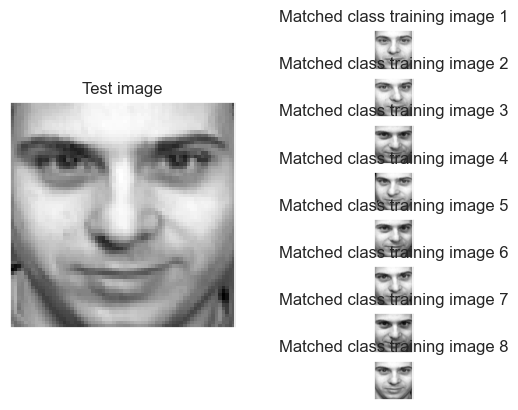

In [120]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.8) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier()).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])

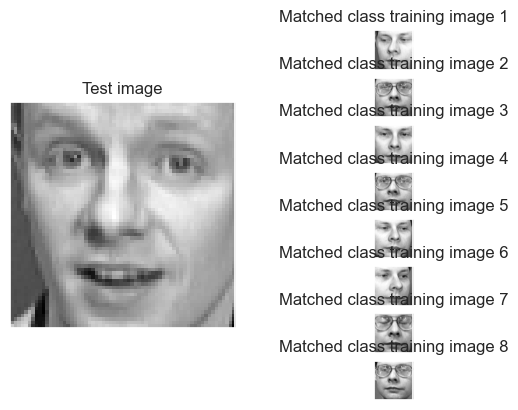

In [131]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.8) # split into training and testing
pca = decomposition.PCA(n_components=10) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(BayesClassifier()).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])